In [1]:
import glob
import random
import pickle
import base64
import pandas as pd

from PIL import Image
from io import BytesIO
from IPython.display import HTML, display
import os
import glob

from helpers.cin_bins import Quantizer
from compressor import Compressor

pd.set_option('display.max_colwidth', -1)  
from dataloaders import cached_listdir_imgs

%matplotlib inline


# p_train_14 = '/home/mentzerf/net_scratch/datasets/train_oi_bpg_q12_10_mixed_bin11'
p_oi_train = ('/home/mentzerf/net_scratch/datasets/train_oi_bpg_q12', None, True)
p_div_val = ('/scratch/mentzerf/datasets/DIV2K/DIV2K_valid_HR_768_new_clean_bpg_q12',)
p_div_train = ('/scratch/mentzerf/datasets/DIV2K/DIV2K_train_HR_768_clean_bpg_q12',)
p_oi_train_mixed = ('/home/mentzerf/net_scratch/datasets/train_oi_bpg_q12_10_mixed_bin11', 512, True)
p_kodak = ('/srv/beegfs02/scratch/cnncompression/data/datasets/kodak_bpg_q12',)
p_oi_top = ('/home/mentzerf/net_scratch/datasets/oi_train_new_top50k_bpg_q12',)

q = Quantizer('/home/mentzerf/net_scratch/datasets/train_oi_bpg_q12_bins_nb20.pkl')

p = p_oi_train

ps_12 = cached_listdir_imgs.cached_listdir_imgs(*p).ps #, min_size=512, discard_shitty=True).ps
# ps_14 = cached_listdir_imgs.cached_listdir_imgs(p_train_14, discard_shitty=False).ps

WRAN: using Agg backend linux
Getting lock for /home/mentzerf/net_scratch/datasets/train_oi_bpg_q12/cached_glob.pkl: .cached_glob.lock [reset: False]...
>>> filter [min_size=None; discard_s=True]: 0.79393


In [2]:
import shutil, torch, collections
import numpy as np

ps_bpsps = sorted([(p, Compressor.bpp_from_compressed_file(p)/3) for p in ps_12], key=lambda xy: xy[1])
# bpsps_14 = sorted([(p, Compressor.bpp_from_compressed_file(p)/3) for p in ps_14], key=lambda xy: xy[1])

# with open('oi_top_50k.txt', 'w') as f:
#     ps_bpsps_top = map(os.path.basename, (p for p, _ in ps_bpsps[-50000:]))
#     ps_bpsps_top = map(Compressor.filename_without_bpp, ps_bpsps_top)
#     f.write('\n'.join(ps_bpsps_top))
    

bpsps = [bpsp for _, bpsp in ps_bpsps]

df = pd.DataFrame(bpsps)

In [3]:

# border     b0    b1     ...   bk         k+1 borders
# bin_idx  0    1      2  ... k    k+1  => k+2 bins
#
# for N bins, we need N-1 borders
# first border is after 1/NB-th of the data

with open(pkl_bins, 'rb') as f:
    print('loading')
    bin_borders_b = pickle.load(f)
    

import matplotlib.pyplot as plt
plt.figure()
# plt.scatter(bin_borders_x, bin_borders_b)
plt.plot(range(len(bpsps)), bpsps)

import bisect
    
xs_rnd = [random.randint(0, len(bpsps)) for _ in range(10)]
ys_rnd = [q.quantize(bpsps[idx]) for idx in xs_rnd]
plt.scatter(xs_rnd, ys_rnd)

# plt.scatter([0, 1], [_quantize(0), _quantize(20)])

a = [_quantize(b) for b in bpsps]
plt.plot(range(len(bpsps)), a)




NameError: name 'pkl_bins' is not defined

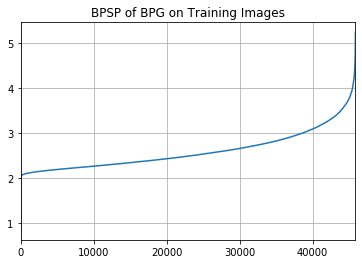

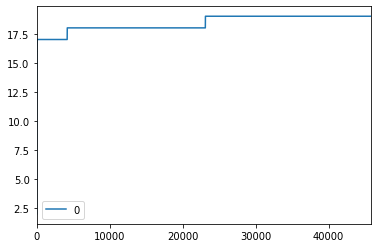

In [62]:
f = df.plot(grid=True, legend=False)
f.set_title('BPSP of BPG on Training Images')


# def _quantize(x, bound_low, bound_high, num_bins):
#     bound_range = bound_high - bound_low
#     return x.clamp(bound_low, bound_high).sub(bound_low).div(bound_range).mul(num_bins-1).round().long()

# CIN_BIN_MIN = 0.5
# CIN_BIN_MAX = 3

# NB=2
# bins = np.linspace(CIN_BIN_MIN, CIN_BIN_MAX, NB)
# bw = bins[1] - bins[0]

# def get_cin_classes(bpsps):
#     """ bpps: (N,) tensor"""
#     return bisect.bisect_right(bin_borders_b, bpsps)
# #     if bpsps >= (bins[6] + bw/2):
# #         return 2
# #     if bpsps >= (bins[3] + bw*3/4):
# #         return 1
# #     return 0
#     return int(_quantize(bpsps, CIN_BIN_MIN, CIN_BIN_MAX, NB))

bins = list(map(q.quantize, bpsps))
pd.DataFrame(bins).plot()

Counter({19: 22739, 18: 18920, 17: 4168, 16: 8, 14: 3, 8: 2, 13: 2, 2: 1, 5: 1, 7: 1, 9: 1, 10: 1, 11: 1, 12: 1})


<BarContainer object of 14 artists>

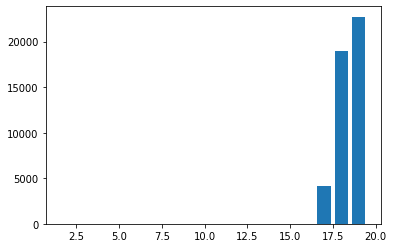

In [63]:
bins = collections.Counter(bins)
print(bins)
bins = sorted(bins.items())
xs = [b for b, c in bins]
ys = [c for b, c in bins]
plt.bar(xs, ys)